# P2 Report 泰坦尼克号乘员获救情况分析

## 项目背景 ##

Titanic可以算的上电影史上最伟大电影之一了，里面太多的情景使人难忘。而实际中Titianic号的沉没，也是世界航海史上一个永恒的话题。本项目打算从数据分析的角度，简单解析一下Titanic号上获救成员的信息。找出在所有乘员中，什么样的人具有最高的生存率。

## 目的 ##

本项目主要解答以下疑问：
 1. 在Titanic事件中，男人和女人的获救情况分别是怎样的？女性是否有更多生还机会？
 2. 当时乘员的年龄分布是怎样的？哪些年龄段的人获救比例最高？
 3. 在许多历史事件中，贫富差异带来的影响都是绕不开的话题，那么在Titanic事件中，富人和穷人生还的几率会有怎样的差别呢？
 4. 综合考虑多个因素，什么样的人，在Titanic事件中获救的可能性最高呢？

## 数据探索 ##

在这个项目中，数据是从Kaggle网站上获取的CSV数据，数据本身相对完整，不需要再进行数据采集。CSV是一个通用性非常强的文本文件格式，许多软件都可以处理CSV文件，比如大名鼎鼎的Excel。但是本项目我打算采用Python作为分析工具对数据进行分析和处理。

建立一个IPython文件来编写代码，首先应当导入本项目中可能用到的库，比如Pandas，matplotlib, seaborn等，代码如下：

In [10]:
    # -*- coding: utf-8 -*-
    import pandas as pd
    import numpy as np
    import seaborn as sns
    from matplotlib import pyplot as plt
    %matplotlib inline

然后需要对数据本身有个大致的了解。利用pandas的read_csv方法读取数据，并将前几行数据打印出来，还可以使用info()方法观察数据的整体状况：

In [11]:
    #从CSV文件中读取数据并存入DataFrame中
    df = pd.read_csv('titanic_data.csv',sep = ',')
    #初步观察数据情况
    df.info()
    #print df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


可以看到，数据集中共有12个字段，891条记录。字段包括乘员姓名、性别、年龄、船舱、获救情况等。参考前面我所关注的几个问题，在数据集中Survived, Sex, Age, Pclass这几个字段将是我重点关注的字段。我将对这几个字段信息进行探索和分析。同时我还注意到，数据集中**Age和Cabin字段存在缺失值**，这个在后面的分析中需要格外注意。

接下来，把Sex, Age, Pclass这几个字段的分布图形画出来，更进一步的了解数据集的情况：

/Users/carrey/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


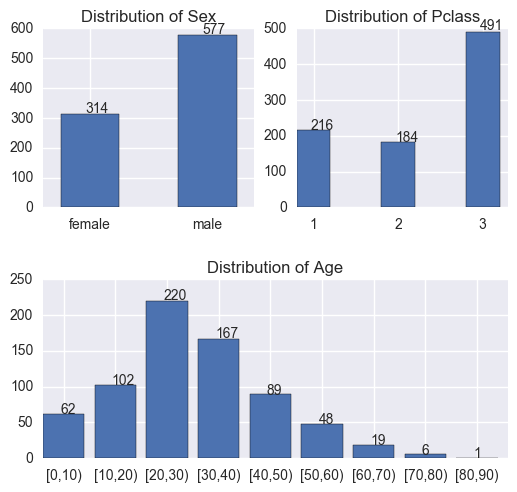

In [12]:
    #观察性别分布情况
    count_by_sex = df.groupby(['Sex'])['Survived'].count()
    #print count_by_sex
    fig = plt.figure()
    ax1 = plt.subplot(221)
    rect = ax1.bar([1,2],count_by_sex.values, width = 0.5, align = 'center')
    ax1.set_title('Distribution of Sex')
    
    #设置X轴刻度：
    def auto_xtricks(rects,xtricks):
        x = []
        for rect in rects:
            x.append(rect.get_x() + rect.get_width()/2)
        x = tuple(x)
        plt.xticks(x,xtricks)
    auto_xtricks(rect,count_by_sex.index)
    
    #设置数据标签数：
    def auto_tag(rects, data = None, offset = [0,0]):
        for rect in rects:
            try:
                height = rect.get_height()
                plt.text(rect.get_x()+rect.get_width()/2.4, 1.01*height, '%s' % int(height))
            except AttributeError:
                x = range(len(data))
                y = data.values
                for i in range(len(x)):
                    plt.text(x[i]-0.2+offset[0],y[i]+0.05+offset[1],y[i])
    auto_tag(rect)
    
    
    #观察舱位分布情况
    count_by_Pclass = df.groupby(['Pclass']).Pclass.count()
    ax2 = plt.subplot(222)
    rect = ax2.bar(count_by_Pclass.index,count_by_Pclass.values,width = 0.4)
    auto_xtricks(rect,count_by_Pclass.index)
    auto_tag(rect)
    ax2.set_title('Distribution of Pclass')
    
    
    #观察年龄分布情况
    drop_null_age = df[df['Age'].notnull()] #由于Age字段存在缺失值，需要将进行清理
    
    #自定义函数，用来获取Age字段值所对应的年龄段
    def get_age_group(age,lim = 10):
        return '[{0},{1})'.format(lim*int(age//lim), lim*int(age//lim) + lim)
    
    #利用pandas的映射功能，针对每一条记录的Age值，算出所在年龄段，并放入GroupAge字段
    drop_null_age['GroupAge'] = drop_null_age['Age'].apply(get_age_group)
    #将数据写入csv文件存档
    drop_null_age.to_csv('drop_null_add_group_age.csv', header = True, index = False)
    
    #将数据按照年龄段分组，计算人数
    group_by_age = drop_null_age.groupby(['GroupAge'])['Survived'].count()
    ax3 = plt.subplot(212)
    rect = plt.bar(range(len(group_by_age)),group_by_age.values)
    auto_xtricks(rect,group_by_age.index)
    auto_tag(rect)
    ax3.set_title('Distribution of Age')
    plt.subplots_adjust(top = 1.2, hspace = 0.4)

上面的图形清楚的展示了Titanic成员的不同分布情况：
1. 乘客中，女性有314人，男性有577人，男性乘客人数远多于女性。
2. 一等舱乘客有216人，二等舱乘客有184人，三等舱乘客有491人。
3. 乘客的年龄分布呈现中间多、两头少的形态，相似于正态分布。在所有乘客中，20-30岁年龄段的人数最多，为220人；80-90岁年龄段人数最少，只有1人。** 需要注意的是，因为年龄数据中存在缺失值，我进行了清理，所以按照年龄分组的数据总和要小于891.**

以上数据展示的是全体乘员的分布状况，我预计获救乘员的分布状况应该有所不同，在下面的数据分析中，我再进行详细的探讨。

## 数据分析 ##

### 第一个问题是：**Titanic上不同性别的乘员构成，以及其获救情况。**  ###

为了更加直观的查看分布情况，我们依然使用matplotlib库对数据进行可视化。具体的执行步骤是：
1. 使用Pandas的groupby()方法对数据按照性别分组；
2. 使用Pandas的count()方法对每组进行计数；
3. 使用Pandas的plot()方法绘制图形。
代码如下：

从上面的输出中我们看到，女性获救人数远远高于男性！在314名女性中，获救的有233名，比例约为74%。在577名男性中，获救的只有109名，比例约为19%。无论从获救人数还是从获救比例来看，女性的生还率都远远高于男性。

由此，在**仅考虑性别**这一因素的情况下，我们大致可以得出这样的判断：** 在Titanic事件中，‘女士优先’这一道德准则被坚定的执行了，乘员中的女性获得了更多的生还机会。**

The survived Rate for Female and Male is:
Sex
female    0.74
male      0.19
Name: Survived, dtype: float64


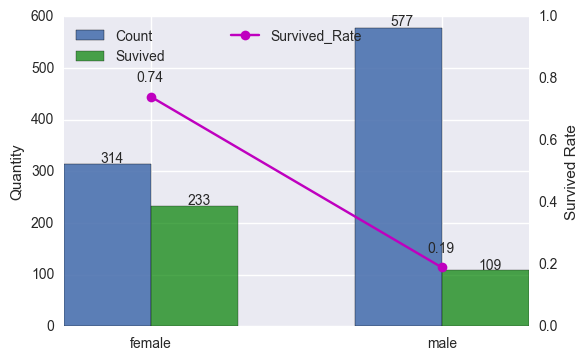

In [13]:
    #计算获救乘员的性别分布
    survived_by_sex = df.groupby(['Sex'])['Survived'].sum()
    #绘制条形图
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    rect = ax1.bar([0,1],count_by_sex.values,width = 0.3, alpha = 0.9)
    rect1 = ax1.bar([.3,1.3],survived_by_sex.values,color = 'g', width = 0.3, alpha = 0.7)
    ax1.set_ylabel('Quantity')
    
    #设定X轴数据
    plt.xticks([.3,1.3],count_by_sex.index) #这里因为两组数据共用一个X轴，不太方便调用函数自动设置，直接指定位置
    
    #设置图例
    plt.legend((rect,rect1),('Count','Suvived'),loc='upper left')
    
    #设置数据标签
    auto_tag(rect)
    auto_tag(rect1)
    
    #计算生还率
    survived_rate_by_sex = (survived_by_sex.apply(float) / count_by_sex.apply(float)).round(2)
    print 'The survived Rate for Female and Male is:'
    print survived_rate_by_sex
    #绘制生还率折线图
    ax2 = ax1.twinx()
    x = [i+.3 for i in range(len(survived_rate_by_sex))]
    y = survived_rate_by_sex.values
    rect2 = ax2.plot(x,y,'mo-', label = 'right')
    #添加数据标签
    auto_tag(rect2,survived_rate_by_sex,offset = [.45,0])
    
    plt.grid(False)
    ax2.set_ylim(0.,1.)
    ax2.set_ylabel('Survived Rate')
    #添加图例
    plt.legend(rect2,['Survived_Rate',], loc = 'upper center')
    

可以看出在记录中的所有成员中，男性为577人，女性为314人。而在获救乘员中，女性为233人，男性为109人，女性远远多于男性！从生还率来说，女性乘客的生还率约为74%，而男性的生还率只有19%。这是一个巨大的差异，考虑到此次考察的数据集总共有近900条记录，因此这个差异不太可能是受随机因素影响而出现的。因此可以大胆推断，** 在Titanic沉船事件逃亡过程中，“女士优先”这一道德准则被坚定的执行了，因此女性乘员获得了更多生还的机会。**

### 第二个问题是：考虑年龄因素，不同年龄段的乘员分布以及其获救情况是怎样的？###

由于对于年龄数据来说，一般不会关注某一个年龄点的信息，更多的是关注某个年龄段的信息。因此就应该考虑将年龄分组（这里我取10年为一个阶段）来进行数据分析。

要画出不同年龄阶段的图形，我们有两种方法：
* 方法一：利用pandas库自带的hist()方法，直接将Age数据传入即可自动分组并绘制出X轴为年龄的直方图；
* 方法二：针对每一条记录，判断记录中Age字段的值属于哪个年龄段，把这个年龄段数据作为一个新的字段添加到原有数据中，然后在利用pyplot中的plot()或者bar()方法，绘制出X轴为年龄段数据的条形图。

在这里，为了绘图更灵活，并且方便进行排序等操作，我采用第二种方法绘制图形。需要注意的是，**由于Age字段有缺失值**，在进行统计、绘图之前，要先清理缺失值，以免影响结论。代码如下：（同时给出方法一的代码）

/Users/carrey/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


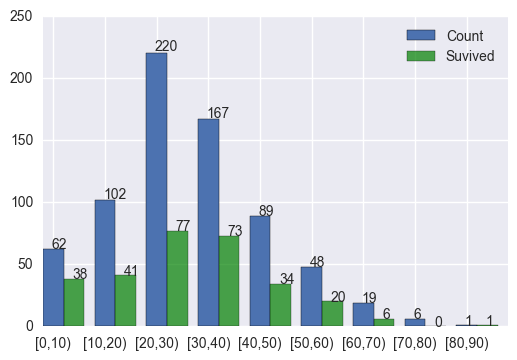

In [14]:
    #清理缺失值。使用内置的notnull()函数建立一个bool值数组，利用该数组对数据集进行索引，即可得到清除了缺失值的数据子集。
    drop_null_age = df[df['Age'].notnull()]
    
    #将得到的数据子集写入csv文件存档。
    drop_null_age.to_csv('titanic_drop_null_Age.csv', index = False, header = True)
    
    #方法一绘制图形
    #survived_by_age = drop_null_age[drop_null_age.Survived == 1]
    #drop_null_age.Age.hist()
    #survived_by_age.Age.hist()
    
    #方法二绘制图形
    #首先创建一个GroupAge字段，该字段每一项的值为对应记录的Age字段值所属的年龄阶段
    ##定义一个函数，用于计算Age字段值对应的年龄阶段
    def get_age_group(age,lim = 10):
        return '[{0},{1})'.format(lim*int(age//lim), lim*int(age//lim) + lim)
    
    #利用pandas的映射功能，针对每一条记录的Age值，算出所在年龄段，并放入GroupAge字段
    drop_null_age['GroupAge'] = drop_null_age['Age'].apply(get_age_group)
    #将数据写入csv文件存档
    drop_null_age.to_csv('drop_null_add_group_age.csv', header = True, index = False)
    
    #将数据按照年龄段分组，计算人数
    group_by_age = drop_null_age.groupby(['GroupAge'])['Survived'].count()
    survived_by_age = drop_null_age.groupby(['GroupAge'])['Survived'].sum()
    
    #绘制图形
    rect = plt.bar(range(len(group_by_age)),group_by_age.values, width = 0.4)
    x = [i + 0.4 for i in range(len(survived_by_age))]
    rect1 = plt.bar(x, survived_by_age.values, width = 0.4, color = 'g', alpha = 0.7)
    #设置数据标签和X轴数据
    auto_tag(rect)
    auto_tag(rect1)
    auto_xtricks(rect, group_by_age.index)
    #设置图例
    plt.legend((rect,rect1),('Count','Suvived'),loc='upper right')
    

从图中我们可以得到以下信息：
1. 获救乘员人数的年龄分布与乘员人数分布的形态比较相似，也是中间高两头低；
2. 虽然20~30岁年龄段的获救人数最多，但是其获救比例看起来比其他年龄段要低一些。

为了更加清楚的了解各年龄段的生还比例，我进行了计算并画出图形：

{'boxes': [<matplotlib.lines.Line2D at 0x112981810>],
 'caps': [<matplotlib.lines.Line2D at 0x112aca6d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x112a9f9d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x112a9f390>],
 'whiskers': [<matplotlib.lines.Line2D at 0x112981990>,
  <matplotlib.lines.Line2D at 0x112aca090>]}

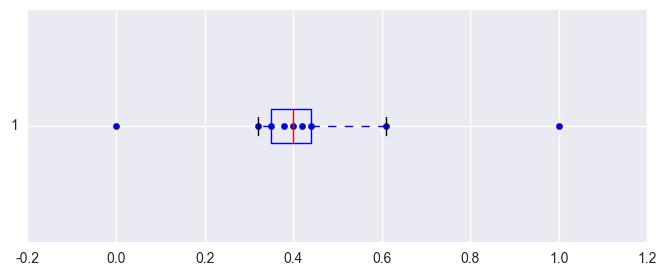

In [15]:
    #生还比例计算
    survived_rate_by_age = survived_by_age.apply(float) / group_by_age.apply(float)
    #自定义函数，四舍五入取前两位小数
    def round_2(float_data):
        return round(float_data,2)
    survived_rate_by_age = survived_rate_by_age.apply(round_2)
    #绘制箱线图及数据点
    y = [1 for i in range(len(survived_rate_by_age))]
    plt.figure(figsize = [8,3])
    plt.scatter(survived_rate_by_age.values,y)
    plt.boxplot(survived_rate_by_age.values,vert = False, whis = [10,90])   

从上面的箱线图和数据点的分布看到，大多数据点集中在0.3到0.6附近的范围内。有两个极值点，0和1。根据经验，一般来说生还率应当是0到1之间的某个值，因此可以猜测这两个极值点的数据可能有问题。为了搞清楚问题所在，进一步画出折线图：

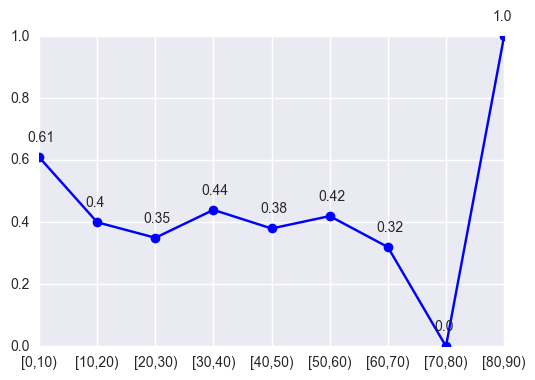

In [16]:
    #画出带数据点的折线图
    x = range(len(survived_rate_by_age))
    y = survived_rate_by_age.values
    rect = plt.plot(x,y,'bo-')
    plt.xticks(x,survived_rate_by_age.index)
    auto_tag(rect, survived_rate_by_age)

从折线图上可以看到，两个极值点对应的年龄段为70-80，和80-90。参考之前的条形图可以知道，这两个年龄段的总人数分别是6人和1人。**由于计算基数太小，因此可以认为对于这两个年龄段，我们计算出的生还率不具备显著的统计学意义。**在分析的时候可以忽略。

对于其他数据点，我们可以得出一些结论：
1. 0-10岁这个年龄段（即儿童）的生还率最高，达到了61%左右；
2. 60-70岁（老年人）的生还率最低，只有32%左右；
3. 青壮年（10-60）人群的生还率在35%-45%之间，其中生还率最低的是20-30岁人群，只有35%左右。

上面这些结论其实非常有趣。一般来讲，由于生理上的差异，在面对灾难时，青壮年人群的生还率要显著高于儿童和老人。但是我们可以看到在Titanic沉船事件中却并非如此。
* 60-70岁的老人生还率确实比较低，这个有两方面的因素可以解释，一是因为这个年龄段的老人生理上处于衰弱期，可能还伴有疾病，因此即便获得了逃生的机会也不一定能够幸存；二是在数据集中这个年龄段人数只有19人，基数偏小，因此计算得出的生还率受随机因素影响较大，代表性不强。

* 对于0-10岁的儿童，我们可以看到生还率远远高于其他年龄段，但是儿童显然不具备很高的自救能力。因此我们可以大胆的推断：**在Titanic沉船事件的逃生过程中，儿童得到了优待明显的优待，因此其生还率显著高于其他年龄段。**

* 最让人诧异的是20-40岁年龄段的数据。一般来讲20-30岁和30-40岁正处于生理状态较好的青年时期，按照常理推断，在灾难中这两个年龄段的人生还率应该相近并且比其他年龄段人群要高，但这与数据集展示出的结论并不相同。20-30岁这个阶段，一般来说处在人生理、体能的巅峰阶段，生还率应该是最高的，但是在本数据集中，这个年龄段的生还率只有35%，属于较低水平。对于这个情况，我不由得**猜测，对于20-30岁这个年龄段来说，正是年轻热血的时期，在面对灾难的时候，许多人就像电影里的主角Jack一样，将生还的机会给了自己的爱人、亲人或者朋友，而自己从容赴死。** 而对于30-40岁这个年龄段来说，也许是人近中年，经历过生活的历练和情感的波折，明白生命的可贵，于是在面对灾难时求生的本能压倒了一切，所以这个年龄段的人有比较高的生还率。** 当然，这些只是我个人的猜测，并没有充分的证据证明这背后的逻辑关系。**

### 第三个问题是：Titanic事件中，富人和穷人生还的几率会有怎样的差别？ ###

从数据集中，我们无法直接判断哪些乘客是富人，哪些是穷人。但是考虑到，一般来讲，有能力乘坐一等舱的应该是经济比较宽裕的人，而乘坐三等舱的乘客应该是经济不那么宽裕的人。因此，我们可以将上述问题简化为：** 不同舱位等级的乘客，其生还率有何不同？**

同样的，把数据按照Pclass字段值分组，并绘制出图形：

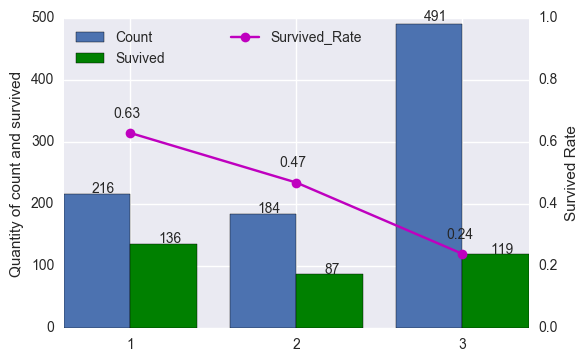

In [17]:
    #按Pclass字段分组，并计算总人数和获救人数
    count_by_Pclass = df.groupby(['Pclass']).Pclass.count()
    survived_by_Pclass = df.groupby(['Pclass']).Survived.sum()
    
    #绘制条形图
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    rect = ax1.bar(count_by_Pclass.index,count_by_Pclass.values,width = 0.4)
    rect1 = ax1.bar(survived_by_Pclass.index + 0.4, survived_by_Pclass.values, width = 0.4,color = 'g')
    ax1.set_ylabel('Quantity of count and survived')
    #设置X轴数据
    plt.xticks(count_by_Pclass.index + 0.4,count_by_Pclass.index)
    #添加数据标签
    auto_tag(rect)
    auto_tag(rect1)
    #添加图例
    plt.legend((rect,rect1),('Count','Suvived'),loc='upper left')
        
    #计算生还率
    survived_rate_by_Pclass = survived_by_Pclass.apply(float) / count_by_Pclass.apply(float)
    survived_rate_by_Pclass = survived_rate_by_Pclass.apply(round_2)
    
    #绘制生还率折线图
    ax2 = ax1.twinx() #公用X轴
    x = [i+1.4 for i in range(len(survived_by_Pclass))]
    y = survived_rate_by_Pclass.values
    rect2 = ax2.plot(x,y,'mo-', label = 'right')
    #添加数据标签
    auto_tag(rect2,survived_rate_by_Pclass,offset = [1.5,0])
    
    plt.grid(False)
    ax2.set_ylim(0.,1.)
    ax2.set_ylabel('Survived Rate')
    #添加图例
    plt.legend(rect2,['Survived_Rate',], loc = 'upper center')
    

这张图给出了非常明确的信息：
1. 数据集中三等舱人数最多，其次是一等舱，二等舱最少；
2. 一等舱生还人数最多，其次是三等舱，二等舱最少；
3. ** 一等舱生还比例最高，为63%；二等舱次之，为47%；三等舱最低，只有24%。** 这是非常明显的阶梯型的差异，一等舱乘客的生还率远高于三等舱，是两倍还多。考虑到舱位等级背后隐含的贫富的差异，我们大概可以**推断：在Titanic沉船事件中，相对富有的人（一等舱乘客）生还率远高于相对贫穷的人（三等舱乘客）。贫富差异造成的生活乃至生存机会的不同，在Titanic事件中同样体现的淋漓尽致！**

### 最后一个问题是：综合考虑多个因素，在Titanic沉船事件中，哪个人群生还几率最高呢？###

这个问题相对于前面三个问题略显复杂，需要从多个角度对其进行分析。不过分析思路是一样的，对数据进行多维度分组，然后绘制出分组数据的相关图形。在这里，我打算从前面提到过的年龄、性别、舱位这三个因素进行分析。代码如下：

In [18]:
    #按照性别、舱位、年龄进行多层分组
    group_by = drop_null_age.groupby(['Sex','Pclass','GroupAge']).count() #计算分组总人数
    survived_by = drop_null_age.groupby(['Sex','Pclass','GroupAge']).sum() #计算分组生还人数
    
    #计算生还率
    survived_rate = (survived_by['Survived'].apply(float) / group_by['Survived'].apply(float)).apply(round_2)
    group_by['SurvivedRate'] = survived_rate  #生还率数据添加进分组数据中
    
    #按照生还率排序，取出生还率高于80%的数据，再按照索引排序
    sorted_data = group_by.sort_values('SurvivedRate', ascending = False)[['Survived','SurvivedRate']]
    highest_survived_rate = sorted_data[sorted_data['SurvivedRate'] > 0.8].sort_index()
    highest_survived_rate.columns = ['Count','SuvivedRate']
    print highest_survived_rate

                        Count  SuvivedRate
Sex    Pclass GroupAge                    
female 1      [10,20)      13         1.00
              [20,30)      16         0.94
              [30,40)      27         1.00
              [40,50)      13         1.00
              [50,60)      12         0.92
              [60,70)       3         1.00
       2      [0,10)        8         1.00
              [10,20)       8         1.00
              [20,30)      25         0.88
              [30,40)      17         0.94
              [40,50)      10         0.90
              [50,60)       6         0.83
       3      [60,70)       1         1.00
male   1      [0,10)        2         1.00
              [80,90)       1         1.00
       2      [0,10)        9         1.00


从上面输出的结果中已经可以明显看到，在高于80%生还率的数据中，几乎都是女性。并且，乘坐的一等舱和二等舱的几乎所有年龄段的女性都具有较高的生还率。从数据中Count字段值看到，有部分分组数据的总人数比较少，其计算出来的生还率不具备显著的统计学意义，所以我将这部分数据剔除：

In [19]:
    print highest_survived_rate[highest_survived_rate['Count'] > 5]

                        Count  SuvivedRate
Sex    Pclass GroupAge                    
female 1      [10,20)      13         1.00
              [20,30)      16         0.94
              [30,40)      27         1.00
              [40,50)      13         1.00
              [50,60)      12         0.92
       2      [0,10)        8         1.00
              [10,20)       8         1.00
              [20,30)      25         0.88
              [30,40)      17         0.94
              [40,50)      10         0.90
              [50,60)       6         0.83
male   2      [0,10)        9         1.00


从这个结果中，我们可以得出非常明确的结论：
1. 一等舱的乘员中，年龄10-60岁之间的女性具有最高的生还率，在90%以上；
2. 二等舱的乘员中，年龄0-60岁之间的女性具有非常高的生还率，在80%以上；
3. 男性乘员中，只有儿童（10岁以下）具有比较高的生还率。乘坐二等舱的男性儿童生还率近乎100%。

除了上面的数据输出之外，其实还可以将不同性别、年龄、舱位的乘客生还率绘制成气泡图，从图中可以直观的得出结论。代码如下：

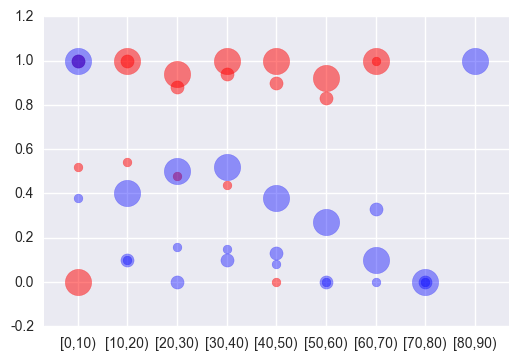

In [20]:
    #将多层索引数据转换成二维
    survived_data = group_by['SurvivedRate']
    unstack_sex_data = survived_data.unstack(0)
    unstack_female_data = unstack_sex_data.female.unstack()
    unstack_male_data = unstack_sex_data.male.unstack()

    #绘制气泡图
    x1 = range(len(unstack_female_data.columns))
    for i in unstack_female_data.index:
        y = unstack_female_data.loc[i].values
        plt.scatter(x1,y,s = 360/(i*i),color = 'r', alpha = 0.5)
    plt.xticks(x1,unstack_female_data.columns)
    
    x2 = range(len(unstack_male_data.columns))
    for i in unstack_male_data.index:
        y = unstack_male_data.loc[i].values
        plt.scatter(x2,y, s = 360/(i*i), color = 'b', alpha = 0.4)


上面的气泡图中，横坐标代表年龄段分布，纵坐标代表乘客生还率。红色的气泡代表女性乘员，蓝色代表男性乘员。大的气泡代表一等舱，中等气泡代表二等舱，最小的气泡代表三等舱。
从图中可以看到：
1. 从10岁直到70岁这个年龄段，几乎所有舱位的女性乘客生还率都高于男性乘员。
2. 乘坐一等舱和二等舱的女性乘客，只要年龄超过10岁，其生还率几乎都在80%以上。

综合上面的分析可以得出：** 生还率最高的人群为：女性，年龄在10-70岁之间，乘坐一等舱或二等舱。其生还率在80%以上。**


### 分析总结 ###

此项目使用pandas库对数据进行了整理和计算，并使用matplotlib库的pyplot模块将数据可视化。通过对数据的计算和对图形的观察，顺利的解决了在项目开始时提出的四个问题。但是需要说明的是，本项目中进行的分析仅仅是从数据本身展现出来的情况进行的，仅仅能表明数据之间的相关关系。在所有的分析结论中，数据之间的因果关系或者逻辑关系，仅仅是一种合理推测，并非严格的统计论证。
本项目仅初步探索了Titanic号沉船事件中，影响生还率的部分因素，并未进行深入的挖掘。待以后有时间，还可以搭建一些机器学习的模型，通过数据训练，来预测未给出数据的乘客生还情况。